# Prueba de Desempeño en Algoritmo de multiplicación de matrices cuadradas
Versión secuencial VS Versión Concurrente

## Selección de Método para medir el tiempo de CPU de Usuario
Se evaluarán primero algunas funciones para medir el tiempo y saber cuál es más precisa para determinar el tiempo de *CPU de usuario*

### Prueba 1 algoritmo secuencial usando time.perf_counter()

In [10]:
import random, time
from resource import getrusage as resource_usage, RUSAGE_SELF
import matplotlib.pyplot as plt

In [18]:
acum = 0
tic = time.perf_counter()
for i in range(200000):
    acum+= i
toc = time.perf_counter()
print(f"Sum in {toc - tic:0.12f} seconds")


Sum in 0.033260000004 seconds


### Prueba 2 algoritmo secuencial usando resource_usage
 'real': end_time - start_time, \
 'sys': end_resources.ru_stime - start_resources.ru_stime, 
 ##### 'user': end_resources.ru_utime - start_resources.ru_utime

In [19]:
acum = 0
start_resources = resource_usage(RUSAGE_SELF)
for i in range(200000):
    acum+= i
end_resources = resource_usage(RUSAGE_SELF)
timeCPU = end_resources.ru_utime - start_resources.ru_utime
print("Sum in {0:.10f} seconds".format(timeCPU))

#print('Result:')
#for r in result:
  # print(r)

Sum in 0.0312500000 seconds


Nota: Para este laboratorio se elegirá resource_usage, ya que aisla de una mejor forma el tiempo de CPU de usuario





# Algoritmo para Multiplicación de Matrices

## Algoritmo secuencial

Definición de las Funciones que se usarán

In [25]:
def reset_to_0(the_array):
    for i, e in enumerate(the_array):
        if isinstance(e, list):
            reset_to_0(e)
        else:
            the_array[i] = 0

#Create matrix
def createMatrix(n):
    a =[]
    b =[]
    r= []
    matrix1 =[]
    matrix2 =[]
    result = []

    for i in range(n):
        for i in range(n):
            number = random.randrange(10)
            number2 = random.randrange(10)
            a.append(number)
            b.append(number2)
            r.append(0)
        matrix1.append(a)
        matrix2.append(b)
        result.append(r)
        a = []
        b = []
        r = []
    return matrix1, matrix2, result

#Prueba de verificacion. No se recomienda su ejecucion para n>10
# print('Matrix 1')
# for m in matrix1:
#     print(m)

# print('Matrix 2')
# for m in matrix2:
#     print(m)

#Multiply Matrix
def multiplyMatrix(matrix1, matrix2, result):
    start_resources = resource_usage(RUSAGE_SELF)
    #iterate through rows of matrix1
    for i in range(n):
       # iterate through columns of matrix2
       for j in range(n):
           # iterate through rows of matrix2
           for k in range(n):
               result[i][j] += matrix1[i][k] * matrix2[k][j]
    end_resources = resource_usage(RUSAGE_SELF)
    timeCPU = end_resources.ru_utime - start_resources.ru_utime
    # print("Matrix multiplication in {0:.10f} seconds".format(timeCPU))
    return timeCPU

# Average Function
def average(list): 
    return sum(list) / len(list)

def averageTime(list1, list2, list3):
    return [average(list1), average(list2), average(list3) ]

def makeChart(xAxis,yAxis):
    plt.bar(xAxis,yAxis)
    plt.title('Matrix Size Vs Average CPU User time')
    plt.xlabel('Matrix Size (N)')
    plt.ylabel('Time (in s)')
    plt.show()

Matrix multiplication in 0.2968750000 seconds
Matrix multiplication in 0.6718750000 seconds
Matrix multiplication in 1.0468750000 seconds
Matrix multiplication in 0.3593750000 seconds
Matrix multiplication in 0.4687500000 seconds
Matrix multiplication in 0.8437500000 seconds
Matrix multiplication in 0.4062500000 seconds
Matrix multiplication in 0.7031250000 seconds
Matrix multiplication in 0.9687500000 seconds
Matrix multiplication in 0.2656250000 seconds
Matrix multiplication in 0.5937500000 seconds
Matrix multiplication in 1.0468750000 seconds
Matrix multiplication in 0.3125000000 seconds
Matrix multiplication in 0.5000000000 seconds
Matrix multiplication in 0.7656250000 seconds
Matrix multiplication in 0.2968750000 seconds
Matrix multiplication in 0.5625000000 seconds
Matrix multiplication in 0.9062500000 seconds
Matrix multiplication in 0.2812500000 seconds
Matrix multiplication in 0.5156250000 seconds
Matrix multiplication in 1.0156250000 seconds
Matrix multiplication in 0.2187500

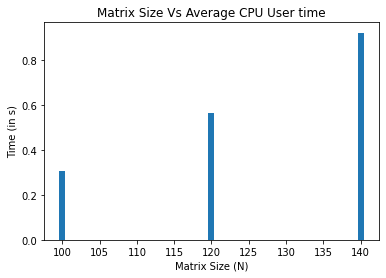

In [27]:

# Main function:
if __name__ == "__main__":

    # Values for n
    matrixSizeN = [100,120,140]
    size100 = []
    size120 = []
    size140 = []

    for i in range (10):
        for n in matrixSizeN:
            matrix1, matrix2, result = createMatrix(n)
            time = multiplyMatrix(matrix1, matrix2, result)
            # print('Multi matrix size: {} . Loop: {} .Time: {}'.format(n,i, time))

            if n== 100:
                size100.append(time)
            elif n == 120:
                size120.append(time)
            elif n == 140:
                size140.append(time)
            else:
                print('Error')
    print(size100)
    print(size120)
    print(size140)

    # xAxis = averageTime    yAxis = matrixSize
    averageTimeList = averageTime(size100, size120, size140)
    # makeChart(xAxis,yAxis)
    makeChart(matrixSizeN, averageTimeList)